# Random Forests 

In [1]:
import init
from common import constants as cn
from common.data_provider import DataProvider
from common import transform_data
from common_python.statistics import empirical_distribution_generator, density, multiple_density, util_statistics
from common_python.plots import util_plots
from plots import util_plots as uplots


from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
import seaborn as sns

%matplotlib inline

## Generate Classification Data

1. T0 is eliminated
1. Normoxia is combined with Resuscitation (because of small number of Normoxia)
1. Perfectly correlated genes are combined

In [2]:
provider = DataProvider()
provider.do()
len(provider.df_normalized)

2582

In [3]:
# Geenrate the feature data
def makeFeatureDF(provider):
    df_Xdata = transform_data.aggregateGenes(provider=provider)
    df_Xdata = df_Xdata.T
    df_Xdata = df_Xdata.drop(index="T0")
    data_features = df_Xdata.columns
    df_Xdata.columns = range(len(data_features))
    return df_Xdata

def makeFeatureColumns(provider):
    df_X = transform_data.aggregateGenes(provider=provider)
    df_X = df_X.T
    return df_X.columns.tolist()


df_Xdata = makeFeatureDF(provider)
df_Xdata.head()

,0,1,2,3,4,5,6,7,8,9,...,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514
T1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


There are only two Noroxia states, one of which is a reference state. So, for the class data, we combine
Noroxia with Resusitation.

In [4]:
# Prepare the state data
def makeClassSer(provider):
    ser_state = provider.df_stage_matrix[cn.STAGE_NAME]
    ser_state = ser_state.drop(index="T0")
    ser_state = ser_state.copy()
    ser_state[ser_state == 'Normoxia'] = 'Resuscitation'
    # Create converter from state name to numeric index
    states = ser_state.unique()
    state_dict = {k: v for v, k in enumerate(states)}
    ser = ser_state.apply(lambda k: state_dict[k] )
    return ser
ser_Ydata = makeClassSer(provider)

## Random Forests for Expression Data

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [6]:
import collections

DecisionTreeResult = collections.namedtuple("DecisionTreeResult",
                                           "top_indices importances clf")

def getTopIndices(num_genes, genes=None, **kwargs):
    """
    :param int num_genes: number of genes in plot
    :param dict kwargs: parameters for RandomForestClassifier
    :return list-int, list-float: indices of the top genes, importances
    """
    clf = RandomForestClassifier(**kwargs)
    df_X = makeFeatureDF(provider)
    if genes is None:
        genes = df_X.columns
    df_X = df_X[genes]
    clf.fit(makeFeatureDF(provider), makeClassSer(provider))
    importances = list(clf.feature_importances_)
    indices = list(np.argsort(importances))
    indices.reverse()
    top_indices = [indices[n] for n in range(num_genes)]
    return DecisionTreeResult(top_indices, importances, clf)

def setRFPlotAttributes(ax):
    _ = plt.ylabel("Importance")
    _ = plt.ylim([0,.1])

def plotRF(num_genes=25, **kwargs):
    """
    :param int num_genes: number of genes in plot
    :param dict kwargs: parameters for RandomForestClassifier
    :return matplotib.Axes:
    """
    fig, ax = plt.subplots()
    result = getTopIndices(num_genes, **kwargs)
    columns = makeFeatureColumns(provider)
    pairs = [(columns[n], result.importances[n]) for n in result.top_indices]
    features, values = zip(*pairs)
    ax.bar(features, values)
    setRFPlotAttributes(ax)
    _ = ax.set_xticklabels(features, rotation='vertical')
    return ax

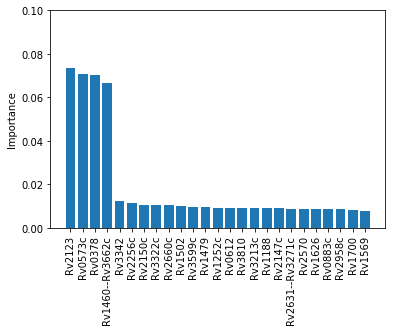

In [7]:
_ = plotRF(n_estimators=1000, max_features=1500, random_state=0,
                            min_samples_split=2, bootstrap=False)

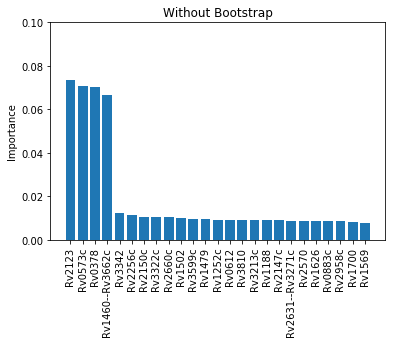

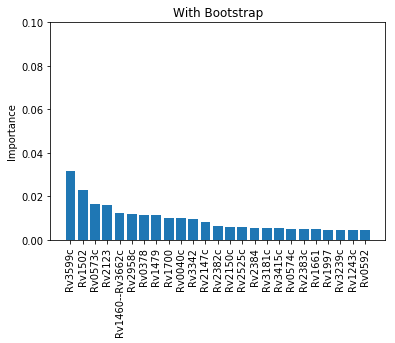

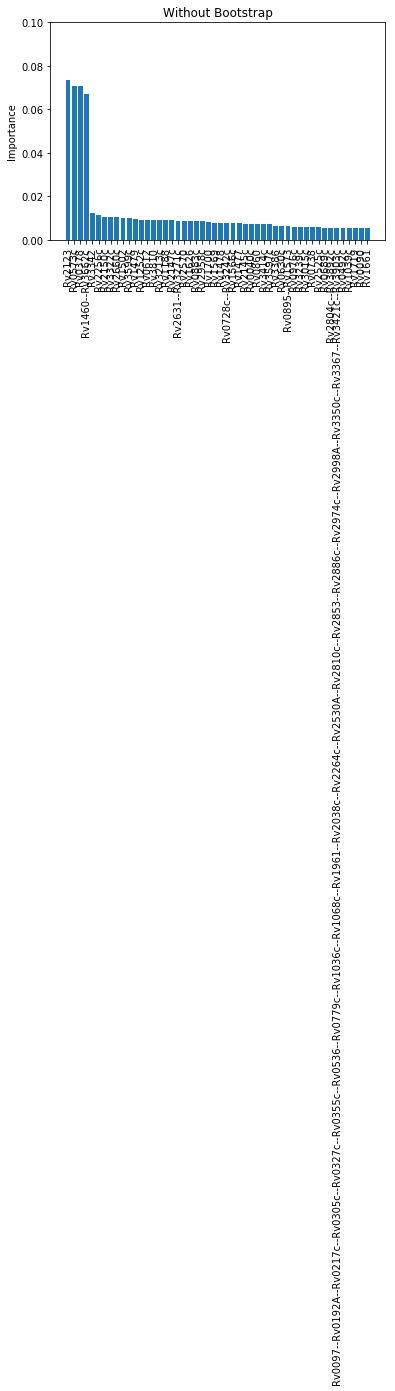

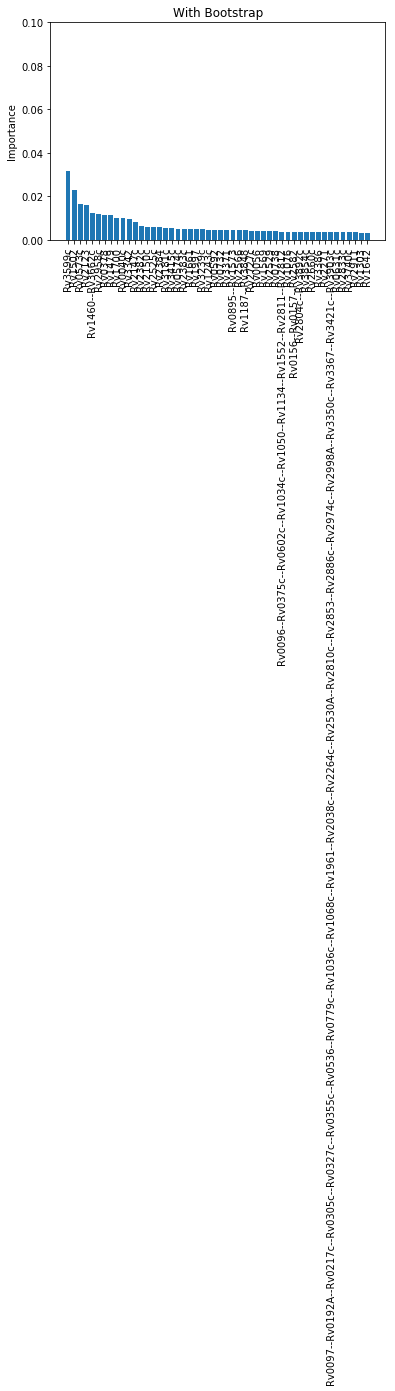

In [8]:
plotRF(n_estimators=1000, max_features=1500, random_state=0,
                            min_samples_split=2, bootstrap=False)
_ = plt.title("Without Bootstrap")
plotRF(n_estimators=1000, max_features=1500, random_state=0,
                            min_samples_split=2, bootstrap=True)
_ = plt.title("With Bootstrap")
plotRF(num_genes=50, n_estimators=1000, max_features=1500, random_state=0,
                            min_samples_split=2, bootstrap=False)
_ = plt.title("Without Bootstrap")
plotRF(num_genes=50, n_estimators=1000, max_features=1500, random_state=0,
                            min_samples_split=2, bootstrap=True)
_ = plt.title("With Bootstrap")

In [9]:
def plotImportanceCDF(num_genes=200, **kwargs):
    result = getTopIndices(num_genes=num_genes, **kwargs)
    importances = result.importances
    importances.sort(reverse=True)
    fig, ax = plt.subplots()
    ax.plot(importances)
    setRFPlotAttributes(ax)
    ax.set_xlim([0, num_genes])
    ax.set_xlabel("Gene")
    return ax

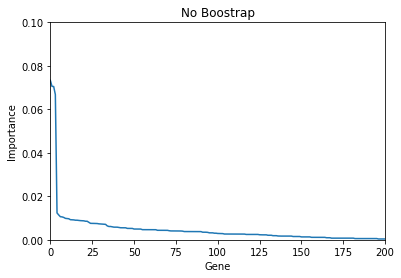

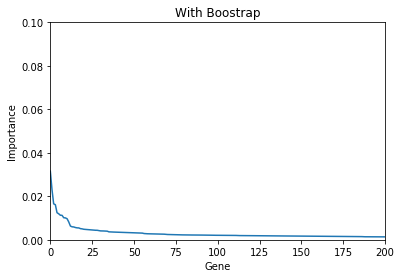

In [10]:
ax = plotImportanceCDF(n_estimators=1000, max_features=1500, random_state=0,
                            min_samples_split=2, bootstrap=False)
ax.set_title("No Boostrap")
ax = plotImportanceCDF(n_estimators=1000, max_features=1500, random_state=0,
                            min_samples_split=2, bootstrap=True)
_ = ax.set_title("With Boostrap")

In [11]:
# Analysis of overlap between bootstrap and non-bootstrap genes
def getCommon(num_genes, **kwargs):
    """
    Calculates the number of genes in common between bootstrap and non-bootstrap.
    :param int num_genes: how many top genes considered
    :param dict kwargs: parameters to classifier
    :return list-int: list of indexes in common
    """
    result_false = getTopIndices(num_genes, bootstrap=False, **kwargs)
    result_true = getTopIndices(num_genes, bootstrap=True, **kwargs)
    return set(result_false.top_indices).intersection(result_true.top_indices)

In [12]:
getCommon(25, n_estimators=1000, max_features=1500, random_state=0,
                            min_samples_split=2)

{152, 153, 225, 226, 287, 717, 718, 1123, 1125, 1378, 1482, 1483}

In [13]:
kwargs = dict(n_estimators=1000, max_features=1500, random_state=0,
                            min_samples_split=2)
values = [len(getCommon(n, **kwargs)) / n for n in [5, 10, 15, 20, 25, 30]]
values

[0.6, 0.5, 0.6, 0.5, 0.48, 0.4]

In [14]:
# Compare the accuracy of trees with all features with those that only have top genes
# Look at clf.oob_score__num_
kwargs = dict(n_estimators=1000, max_features=1500, random_state=0,
                            min_samples_split=2, bootstrap=True, oob_score=True)
values = getCommon(25, n_estimators=1000, max_features=1500, random_state=0,
                            min_samples_split=2)
num_genes = len(values)
result = getTopIndices(num_genes, genes=list(values), **kwargs)
result.clf.oob_score_

0.88

In [15]:
num_genes = 25
result = getTopIndices(num_genes, **kwargs)
result.clf.oob_score_

0.88

### Observations
1. Significant overlap between bootstrap and non-bootstrap features
1. Try DT with top N features.

In [16]:
clf = RandomForestClassifier(n_estimators=1000, max_features=1500, random_state=0,
                            min_samples_split=2, bootstrap=True)
clf.fit(makeFeatureDF(provider), makeClassSer(provider))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1500, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [20]:
tree = clf.estimators_[0]

In [26]:
tree.n_features_

1515